# Detecting Alcohol Intoxication Using Cell Phone Accelerometer Data
> Aswin Rajkumar

## Introduction
The aim of this experiment is to **predict whether the user is intoxicated or not using a 10-second long accelerometer data stream**. A person is considered intoxicated if the Transdermal Alcohol Concentration (TAC) level is above `0.8`. Cell phone acccelerometer data used for this analysis was collected from 13 participants by [Killian, J.A., Passino, K.M., Nandi, A., Madden, D.R. and Clapp, J., Learning to Detect Heavy Drinking Episodes Using Smartphone Accelerometer Data. In Proceedings of the 4th International Workshop on Knowledge Discovery in Healthcare Data co-located with the 28th International Joint Conference on Artificial Intelligence (IJCAI 2019) (pp. 35-42)](http://ceur-ws.org/Vol-2429/paper6.pdf).

For having a fresh perspective on analyzing the dataset, I only used the information in the resource for understanding the data and skipped the analysis section. This is also a time-blocked exercise that I completed within 2 days. Hence, I mention multiple ideas in the future work section to expand on this initial analysis.

## Methods

Multiple ways of joining - timestamp unit conversion, join based on TAC timestamp + 9 seconds and ignore no matches or not enough samples, assigning same tac to all ten seconds, fuzzy matching, interpolation

For now, I'm going to split the segments by 10 and add overlap using hop_length so the effects of wrong sampling is minimized.


## Analysis
### Setup

In [172]:
# Imports
import os
import glob
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
from scipy.interpolate import interp1d
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Utility functions
def plot_series(x, label, ylow=-0.8, yhigh=0.8):
    x = x.sort_values(by=['time'])
    fig, ax = plt.subplots()
    ts = np.linspace(1, 10, len(x))
    ax.plot(ts, x.x)
    ax.plot(ts, x.y)
    ax.plot(ts, x.z)
    ax.set_ylim(ylow, yhigh)
    plt.xlabel('seconds')
    plt.ylabel('amplitude')
    plt.title(f'Accelerometer Readings: {label}')

def plot_stft(df):
    def plot_axis(vals, ax):
        X = librosa.amplitude_to_db(np.abs(librosa.stft(vals, n_fft=frame, hop_length=frame, center=False)), ref=np.max)
        display.specshow(X, y_axis='linear', x_axis='s', sr=frame, hop_length=frame, ax=ax)
    sample_rate = 40
    segment_length = df.shape[0]
    frame = segment_length//num_frames # Segment_length constitutes 10 seconds. After cleaning, just assign sample_rate
    fig, ax = plt.subplots(1,3, figsize=(15,8))
    fig.suptitle(f"STFT for TAC {np.round(df.TAC_Reading.dropna().unique()[0],4)} with segment_length : {segment_length}, sample_rate : {frame}")
    plot_axis(df.x.values, ax[0])
    plot_axis(df.y.values, ax[1])
    plot_axis(df.z.values, ax[2])

# Values
acc_df = pd.read_csv(os.path.join('data', 'all_accelerometer_data_pids_13.csv'))
pids = pd.read_csv(os.path.join('data', 'phone_types.csv'))

### Quick Look

    timestamp  TAC_Reading
0  1493718714    -0.000482
1  1493720697     0.001573
2  1493721027     0.002144
3  1493721357     0.000877
4  1493721686    -0.001145


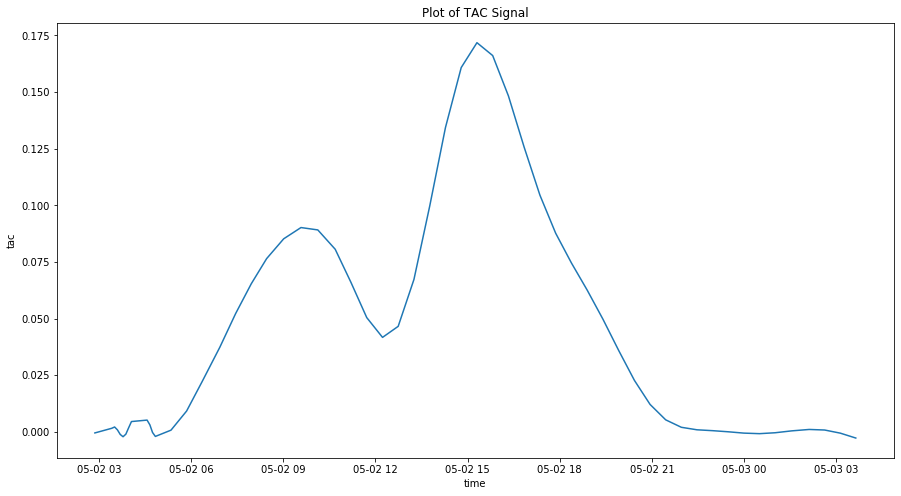

In [124]:
# Quick look at TAC data
df = pd.read_csv('data/clean_tac/BK7610_clean_TAC.csv')
print(df.head())
_, _ = plt.subplots(figsize=(15,8))
plt.plot(df['timestamp'].map(datetime.fromtimestamp), df['TAC_Reading'])
plt.xlabel('time')
plt.ylabel('tac')
plt.title('Plot of TAC Signal')
plt.show()

### Time Domain
The samples can be transformed into temporal and frequency information that would represent how the pariticipant was moving during that time frame. From domain knowledge, we may assume intoxicated movements to be somewhat irregular. However, human beings do not move continuously and we only have a 10 second window to analyze. Temporal infomation may not tell us much. Let's analyze using plots.

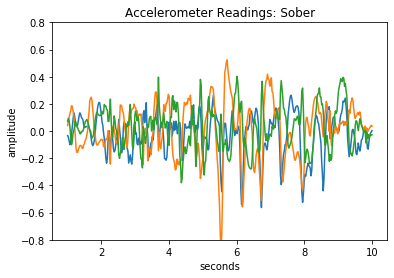

In [169]:
# Setup
tac1 = pd.read_csv('data/clean_tac/BK7610_clean_TAC.csv')
acc1 = acc_df[acc_df.pid == 'BK7610'].copy()
acc1['timestamp'] = acc1.time.map(lambda x:x//1000)
acc1 = pd.merge(acc1,tac1, on='timestamp', how='left')
acc1.timestamp.value_counts()

# Time plot
x = acc1[acc1.TAC_Reading == np.sort(acc1.TAC_Reading.unique())[0]]
start, end = x.timestamp.iloc[0], x.timestamp.iloc[0]+9
min_tac_df = acc1[(start <= acc1.timestamp) & (acc1.timestamp <= end)]
plot_series(min_tac_df, "Sober")

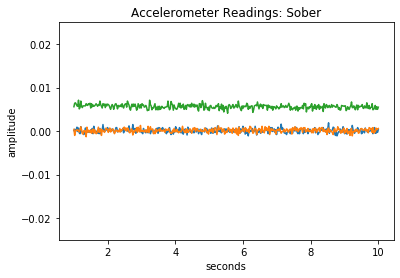

In [103]:
x = acc1[acc1.TAC_Reading == np.sort(acc1.TAC_Reading.unique())[1]]
start, end = x.timestamp.iloc[0], x.timestamp.iloc[0]+9
min_tac_df = acc1[(start <= acc1.timestamp) & (acc1.timestamp <= end)]
plot_series(min_tac_df, "Sober", -0.025, 0.025)

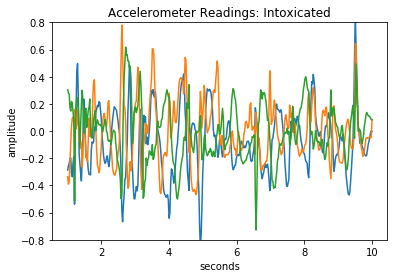

In [104]:
x = acc1[acc1.TAC_Reading == np.sort(acc1.TAC_Reading.unique())[::-1][6]]
start, end = x.timestamp.iloc[0], x.timestamp.iloc[0]+9
max_tac_df = acc1[(start <= acc1.timestamp) & (acc1.timestamp <= end)]
plot_series(max_tac_df, "Intoxicated")

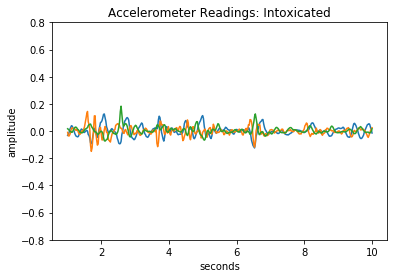

In [107]:
x = acc1[acc1.TAC_Reading == np.sort(acc1.TAC_Reading.unique())[::-1][1]]
start, end = x.timestamp.iloc[0], x.timestamp.iloc[0]+9
max_tac_df = acc1[(start <= acc1.timestamp) & (acc1.timestamp <= end)]
plot_series(max_tac_df, "Intoxicated")

The signal plots look different even within the same class. However, there seem to be more peaks and variance in the plots for intoxicated class.

### Frequency Domain

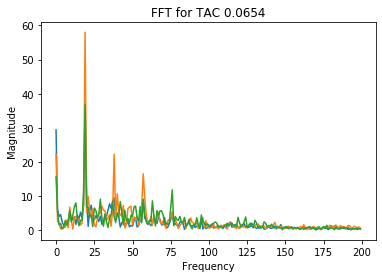

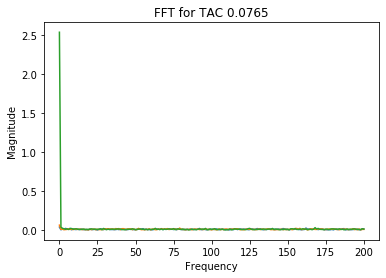

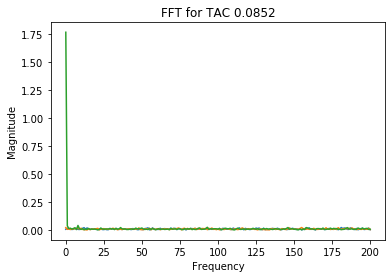

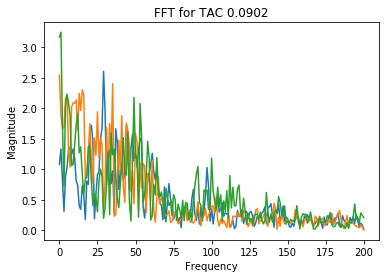

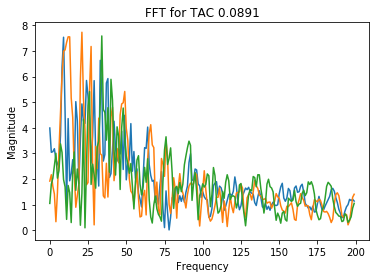

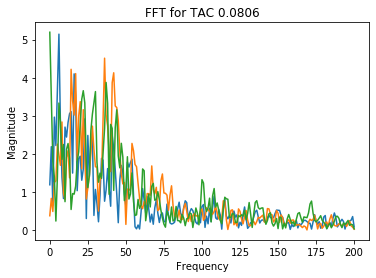

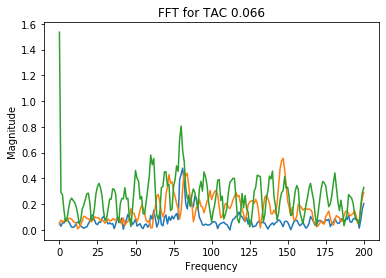

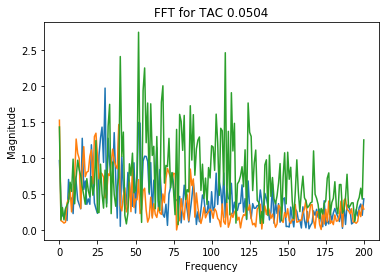

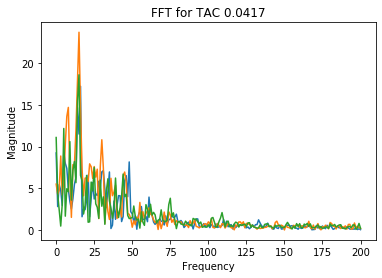

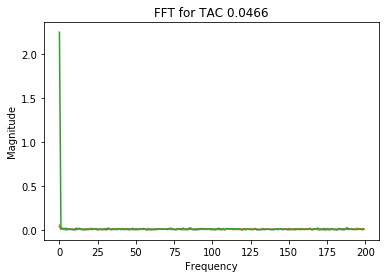

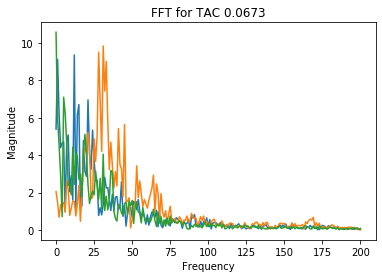

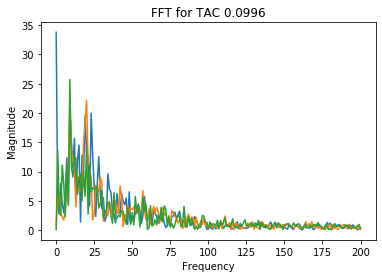

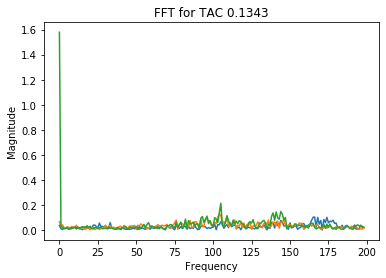

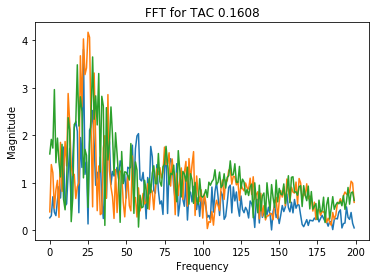

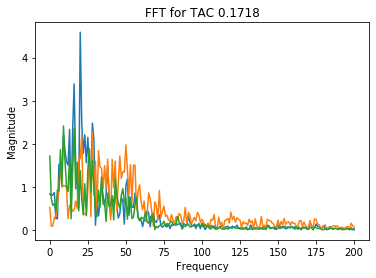

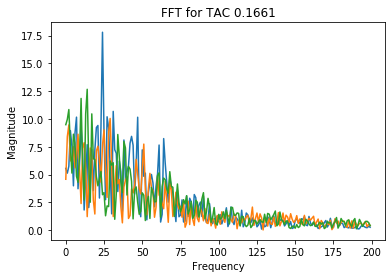

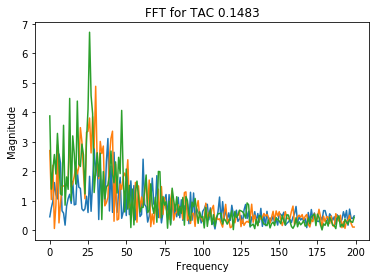

In [166]:
for start, end in zip(start_times, end_times):
    df = acc1[(start <= acc1.timestamp) & (acc1.timestamp <= end)]
    fig, ax = plt.subplots()
    plt.title(f"FFT for TAC {np.round(df.TAC_Reading.dropna().unique()[0],4)}")
    ax.plot(np.abs(np.fft.rfft(df.x)))
    ax.plot(np.abs(np.fft.rfft(df.y)))
    ax.plot(np.abs(np.fft.rfft(df.z)))
    plt.xlabel('Frequency')
    plt.ylabel('Magnitude')
    plt.show()

We see a lot of variation in frequency domain within the same class as well.

### Spectral Information
Here, we combine frequency and time information in one spectrogram called Short-Term Fourier Transform.

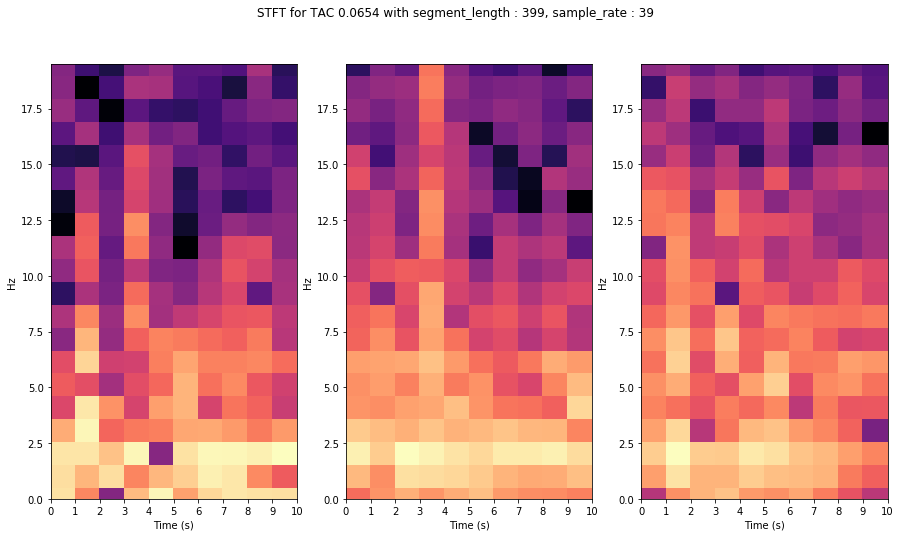

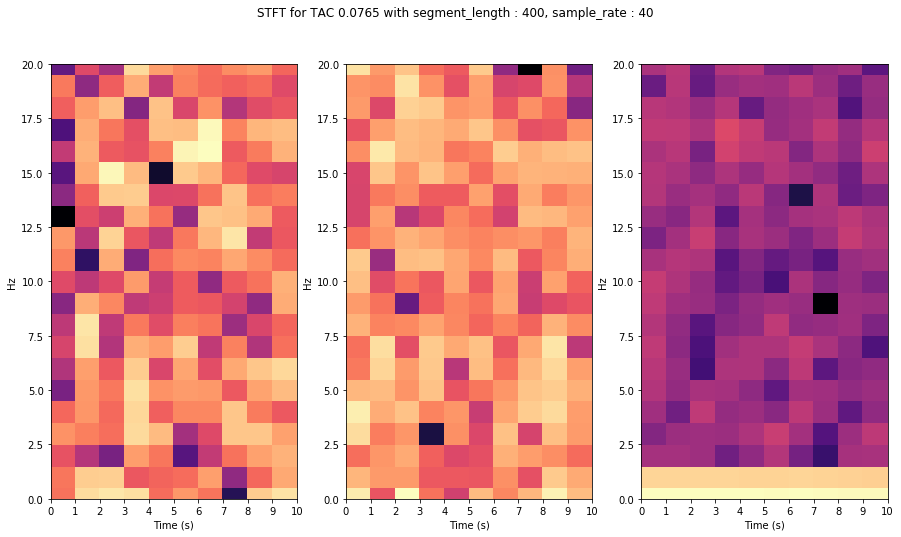

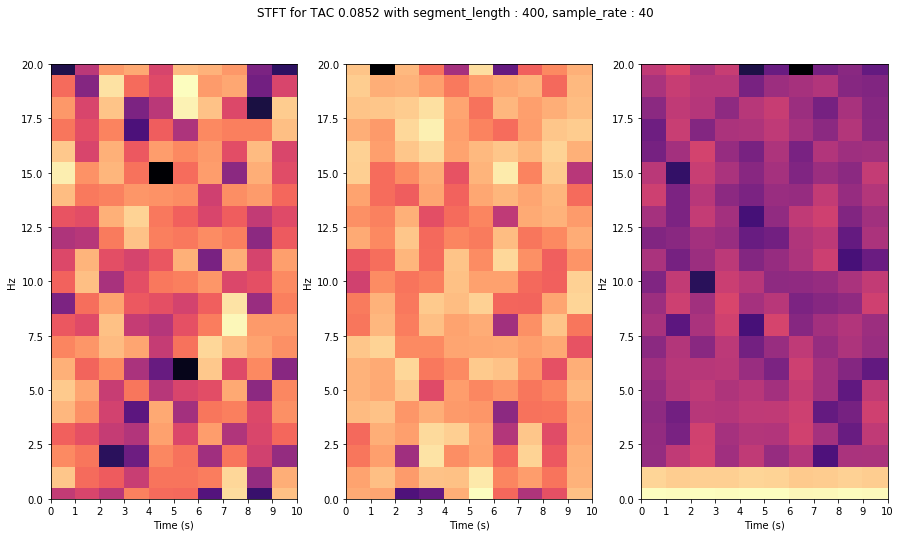

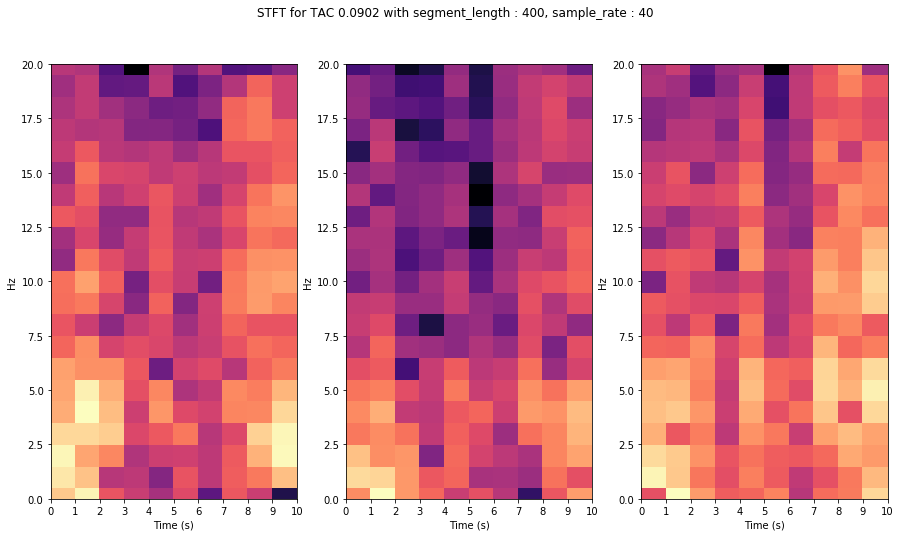

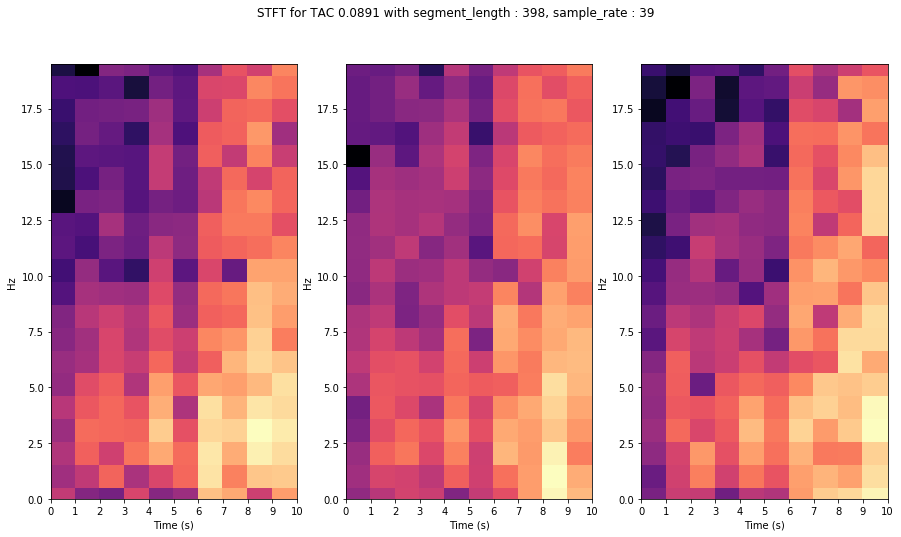

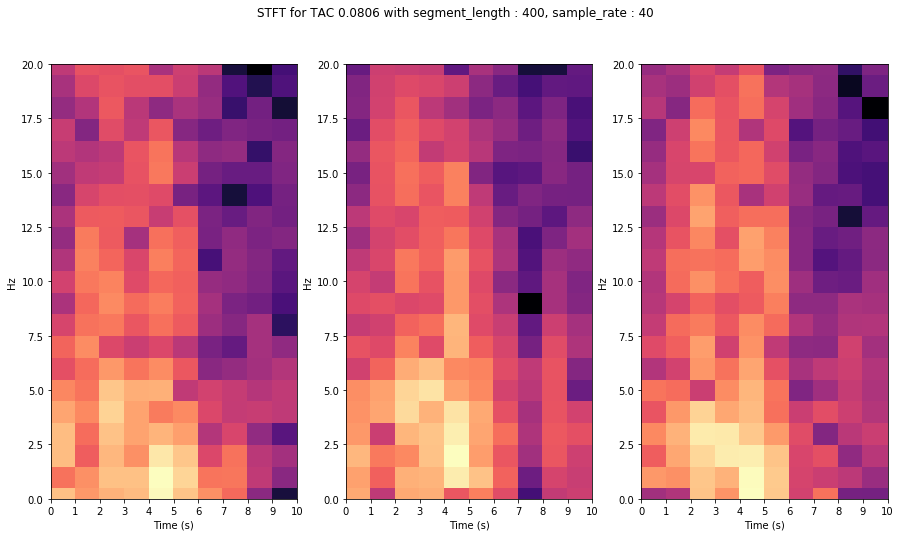

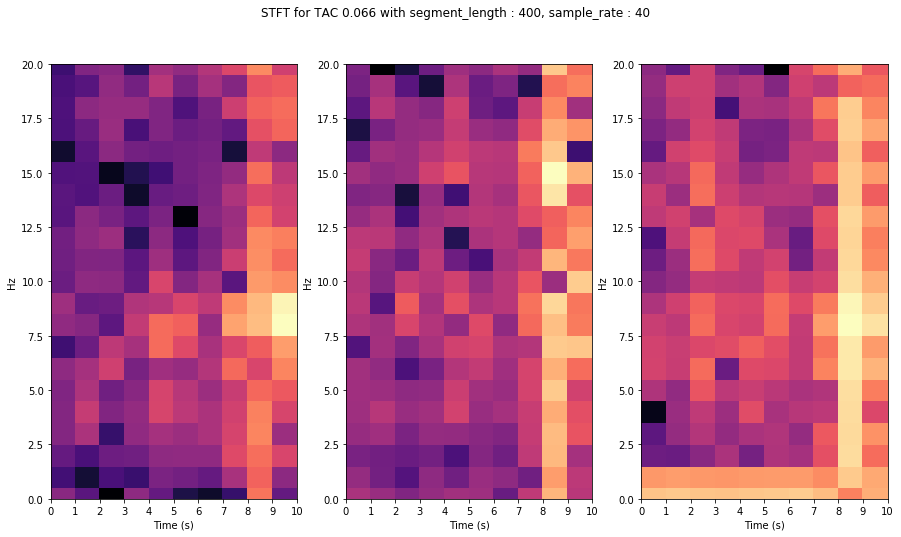

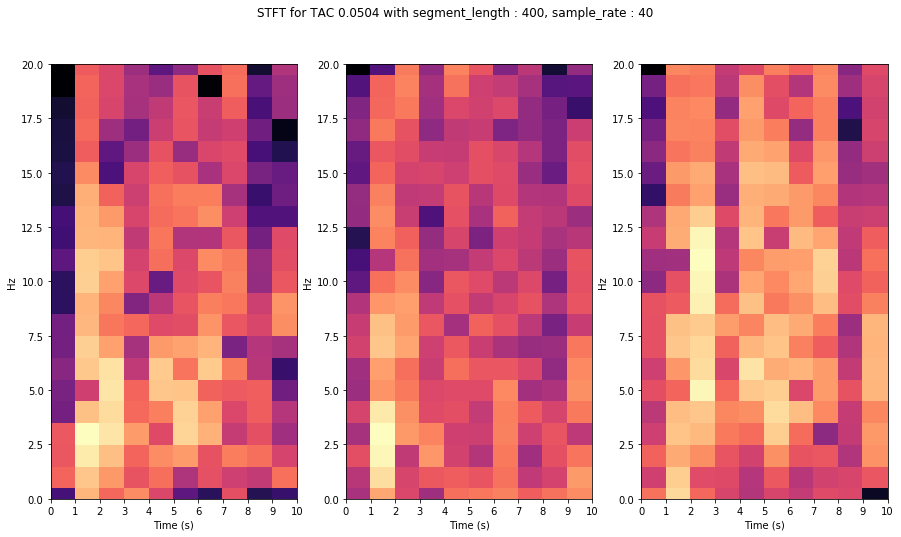

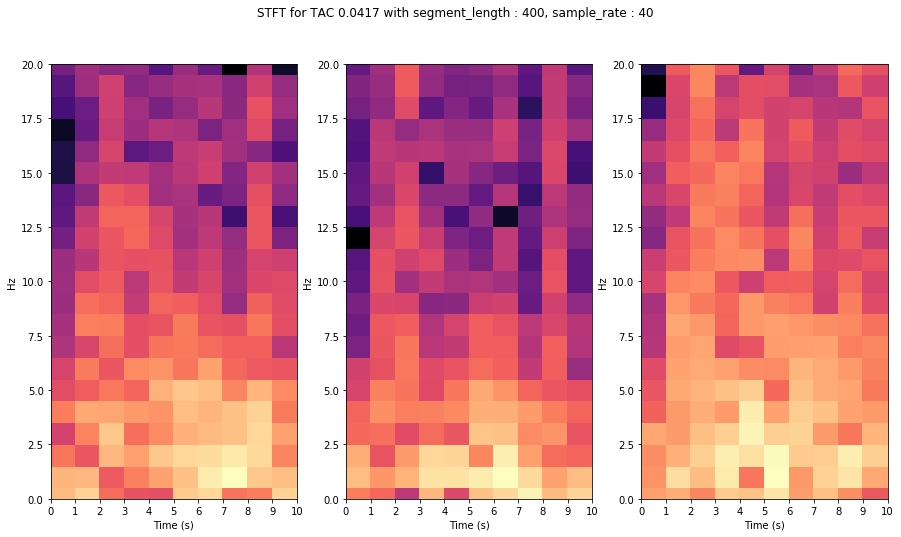

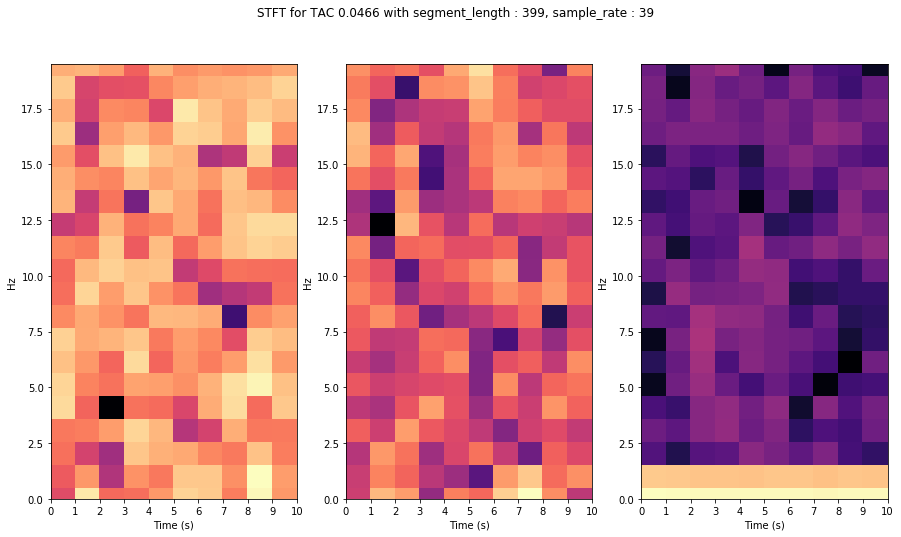

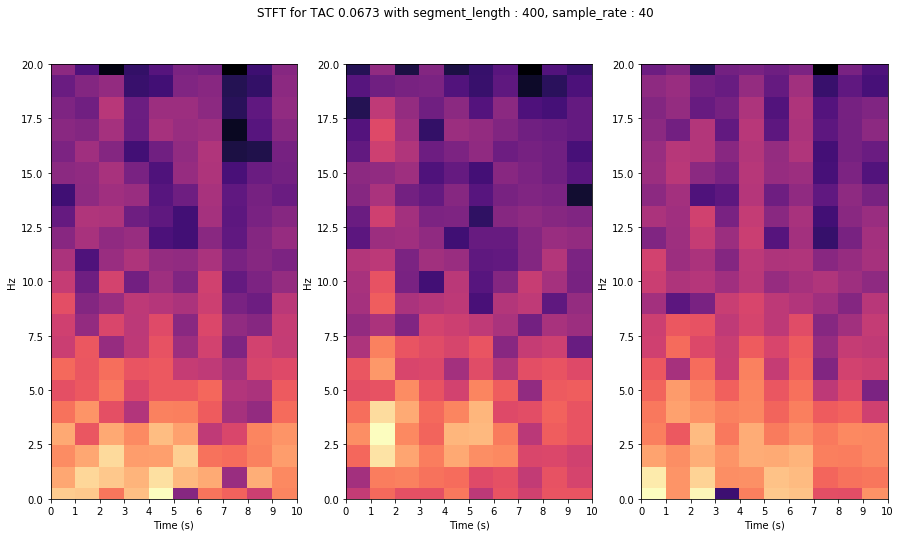

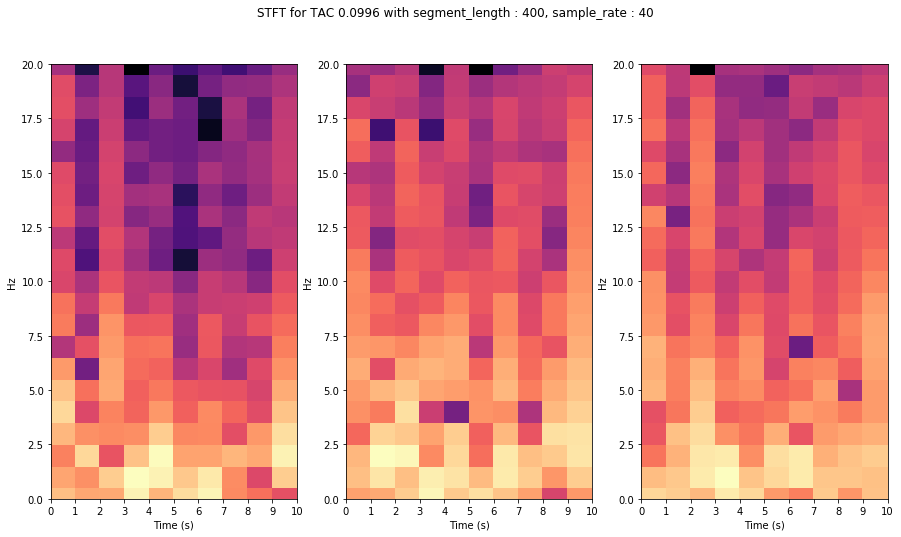

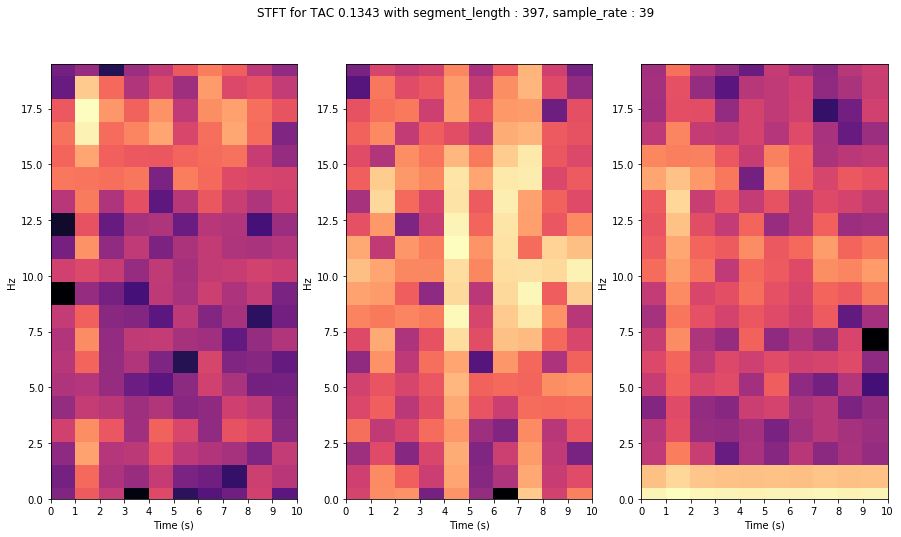

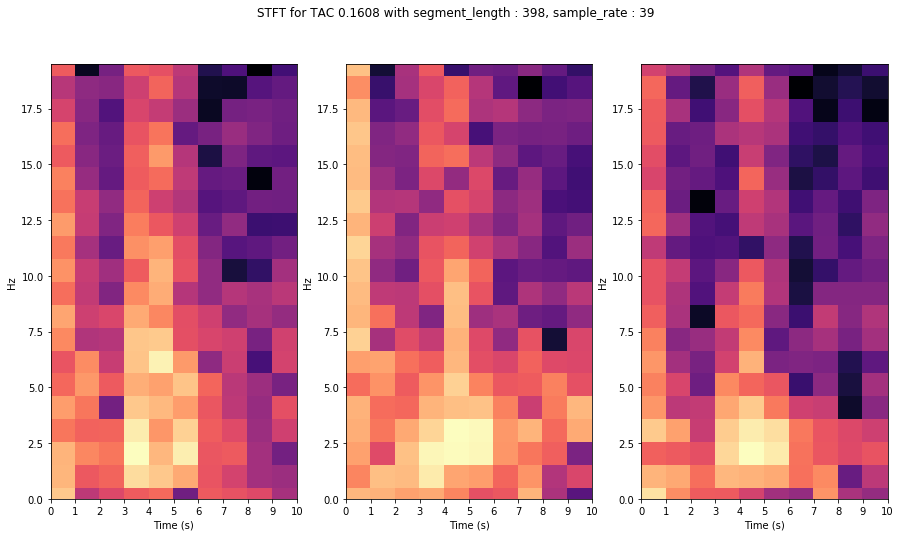

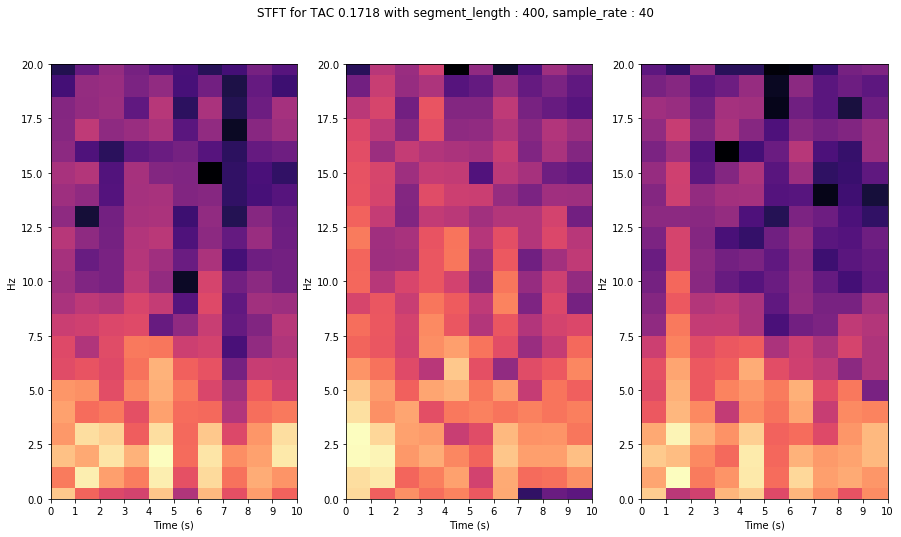

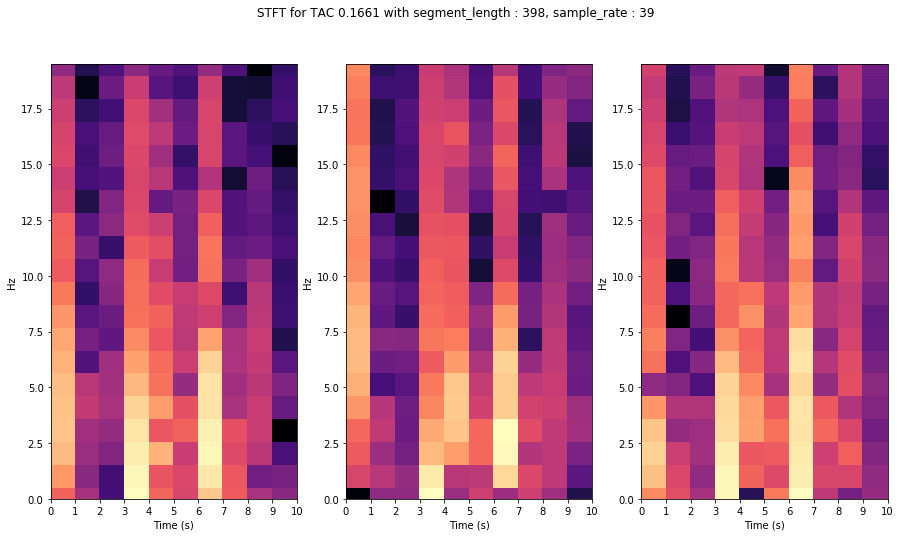

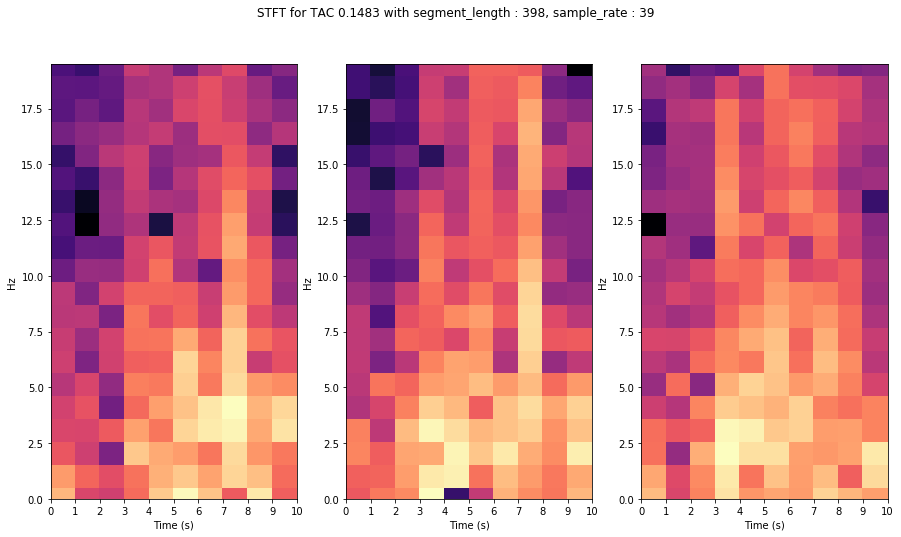

In [163]:
num_frames = 10   

start_times = acc1[acc1['TAC_Reading'].notna()].timestamp.unique()
start_times.sort()
end_times = start_times+9
for start, end in zip(start_times, end_times):
    df = acc1[(start <= acc1.timestamp) & (acc1.timestamp <= end)]
    plot_stft(df)
    plt.show()

The spectrograms do not have any obvious patterns for us to recognize the intoxication level. However, with enough combined frequency and temporal information, we can train a classifier to predict whether the user is intoxicated or not.

## Data
I used `clean_tac` data, which contains the cleaned TAC Readings for each participant.
- Join TAC readings with accelerometer data
    - Timestamp unit of TAC data is in seconds while the accelerometer timestamps are in milliseconds
- Sort the accelerometer data based on `time` column, which is the unix millisecond recording timestamp.
mOut of order? Sort before using
- Extract signals of window length 10 seconds and frame length 40 samples.
- Feature extraction of temporal and frequency information

Things to deal with
- Accelerometer sampling rate is not 40 hz consistently
- TAC Readings are not exactly once every 30 minutes
- Joining the datasets is not entirely straightforward.
- Cleaning: 
we have to make sure the sampling rate is consistent across the windows, right?
Process and even remove all windows with num_samples < 40
To create train/test set, we have to pivot and create 10 second signals for x,y,z. We have to take sections for each pid group, not just time based. Let's study BK7610 first

Initial Idea:

Take stats values for each of the short term windows and create a feature set of 30 values for each stat.
Maybe also add amp feature like RMS per frame.
Maybe also add FFT over the entire 10 seconds. - splitting n calculating for frames is what STFT does. So no need to repeat it manually. Instead, Take min, max and mean FFT for each axis over 10 seconds.
If time, Mel spectro. MFCC too? For MFCC, they took covariance matrix 13x13, against self XxX, XxY and XxZ, YxY, ZxZ and YxZ?. then flattened it as features.

So, STFT covariance, STFT stats features and amp + fft.

Data: Shuffle and split into train test eval.

Then Dimensionality Reduction?

Since we are taking activity from t to t+9 seconds and matching with the TAC reading at t, our prediction will slightly conservative - well not really cos we're talking about just seconds. We can try repeating the experiment by using t as the mid(-ish) point. t-4 to t+5

We could also set TAC_Reading for all samples between t to t+30minutes-ish when the next reading is taken.

There are not too many matches when it comes to timestamp in seconds. Find nearest TAC reading if withing 10 mins or something? Maybe we can double the data set by taking the the previous 10 seconds and train to the same label
`acc_df[np.abs(acc_df.timestamp-1493798439) < 10]`
Timestamps missing - `set(starts) - set(bk_acc.timestamp.unique())`

### Missing Data and Cleaning

Here, we check if sample_rate is consistent for all 10 second accelerometer data corresponding to TAC Readings. Higher number of samples can be resampled into 40 hz. Hence, let's check undersampled sections

In [170]:
tac2 = pd.read_csv('data/clean_tac/JB3156_clean_TAC.csv')
acc2 = acc_df[acc_df.pid == 'JB3156'].copy()
acc2['timestamp'] = acc2.time.map(lambda x:x//1000)
acc2 = pd.merge(acc2,tac2, on='timestamp', how='left')
start_times = acc2[acc2['TAC_Reading'].notna()].timestamp.unique()
start_times.sort()
end_times = start_times+9

for start, end in zip(start_times, end_times):
    df = acc2[(start <= acc2.timestamp) & (acc2.timestamp <= end)]
    if df.shape[0] < 300:
        print(df.groupby('timestamp')['timestamp'].agg('count'))

timestamp
1493749820    50
1493749821    50
1493749822    44
1493749827    23
1493749828    50
1493749829    49
Name: timestamp, dtype: int64
timestamp
1493779295    48
1493779302    25
1493779303     7
Name: timestamp, dtype: int64
timestamp
1493782978    17
1493782986    24
1493782987    43
Name: timestamp, dtype: int64


As we can see, there are multipe seconds that are sampled at less than 40 hz. There are also sections which do not have complete 10 seconds of accelerometer signal.

### Data Transformation

Let's join all TAC Readings so that we can join the readings with the accelerometer data.

In [181]:
def tac_readings(pid):
    fname = glob.glob(os.path.join('data', 'clean_tac', f'{pid}*.csv'))[0]
    df = pd.read_csv(fname)
    df['pid'] = pid
    return df
all_tacs = pd.concat(pids.pid.apply(tac_readings).to_list())
all_tacs.head()

,timestamp,TAC_Reading,pid
0,1493718714,-0.000482,BK7610
1,1493720697,0.001573,BK7610
2,1493721027,0.002144,BK7610
3,1493721357,0.000877,BK7610
4,1493721686,-0.001145,BK7610


#### Join Method: Inflate TAC Readings
In this method, we inflate the TAC Readings to cover the 10 second window by duplicating each entry 9 times for t+1 to t+9 seconds. I would use the resulting dataframe to find matches in the accelerometer dataset. I find the corresponding timestamp in seconds for each accelerometer recording by dividing the unix timestamp by 1000.

In [182]:
# inflate dataframe to cover 10 seconds.
all_tacs_full = pd.DataFrame()

def inflate(row):
    global all_tacs_full
    for i in range(10):
        all_tacs_full = all_tacs_full.append([[row.timestamp+i, row.TAC_Reading, row.pid]])

all_tacs.apply(inflate, axis=1)
all_tacs_full.reset_index(drop=True, inplace=True)
all_tacs_full.columns = all_tacs.columns
all_tacs_full

,timestamp,TAC_Reading,pid
0,1493718714,-0.000482,BK7610
1,1493718715,-0.000482,BK7610
2,1493718716,-0.000482,BK7610
3,1493718717,-0.000482,BK7610
4,1493718718,-0.000482,BK7610
...,...,...,...
7145,1493805315,-0.002919,SF3079
7146,1493805316,-0.002919,SF3079
7147,1493805317,-0.002919,SF3079
7148,1493805318,-0.002919,SF3079


##### Limited Signals

In [184]:
# now merge with accelerator df
# pd.merge(acc_df, all_tacs_full, on=[''])
acc_df['timestamp'] = acc_df.time // 1000
acc_df_merged = pd.merge(acc_df, all_tacs_full, on=['timestamp', 'pid'], how='left')
X = acc_df_merged[acc_df_merged.TAC_Reading.notna()]

In [193]:
print(f"Total number of input signals assuming 40 hz sampling rate = {X.shape[0]//400}")

Total number of input signals assuming 40 hz sampling rate = 154


The issue with the above method is there are very few matches between the two dataframes based on timestamp (seconds). We cannot reliably train a classifier with limited data.

##### Invalid Sampling Rate
Another issue is that not all time windows have enough accelerometer data samples.

In [198]:
# for start in starts:
windowed = pd.DataFrame()
def segment(pid):
    global windowed
    starts = all_tacs[all_tacs.pid==pid].timestamp
    recorded_timestamps = set(X.timestamp)
    for start in starts:
        if start in recorded_timestamps:
            df = X[(X.pid==pid) & ((start <= X.timestamp) & (X.timestamp <= start+9))]
            df = df.sort_values(by=['time'])
            if df.shape[0] > 350 and df.shape[0] < 450:
                windowed = windowed.append([[df.iloc[0].pid, df.iloc[0].timestamp, df.x.values, df.y.values, df.z.values, df.iloc[0].TAC_Reading]])
            else:
                print(f"Bad 10 second window: with {df.shape[0]} samples starting at {start} for {pid}")
_ = pids.pid.map(segment)
windowed.columns = ['pid', 'start_time_s', 'x', 'y', 'z', 'TAC']

Bad 10 second window: with 0 samples starting at 1493737046 for BU4707
Bad 10 second window: with 0 samples starting at 1493738847 for BU4707
Bad 10 second window: with 0 samples starting at 1493740845 for BU4707
Bad 10 second window: with 0 samples starting at 1493742871 for BU4707
Bad 10 second window: with 0 samples starting at 1493756113 for BU4707
Bad 10 second window: with 0 samples starting at 1493757960 for BU4707
Bad 10 second window: with 0 samples starting at 1493759807 for BU4707
Bad 10 second window: with 0 samples starting at 1493761652 for BU4707
Bad 10 second window: with 0 samples starting at 1493763497 for BU4707
Bad 10 second window: with 0 samples starting at 1493765341 for BU4707
Bad 10 second window: with 0 samples starting at 1493767186 for BU4707
Bad 10 second window: with 106 samples starting at 1493741188 for CC6740
Bad 10 second window: with 195 samples starting at 1493772526 for CC6740
Bad 10 second window: with 37 samples starting at 1493776216 for CC6740
B

We can see that invalid sampling rate further reduces the amount of data we have to train a classifier on. For example, not data for PID 'SA0297' is in the transformed dataframe!

In [200]:
windowed.pid.value_counts()

PC6771    19
CC6740    19
BK7610    17
DK3500    16
HV0618    15
SF3079     9
MJ8002     8
DC6359     8
BU4707     6
MC7070     5
JR8022     3
JB3156     1
Name: pid, dtype: int64

#### Join Method: Using Interpolation
Since I did not find enough matches when joining the dataframes due to timestamp mismatches or invalid sampling rate, I decided to not perform join at all. Instead, I use interpolation to find the TAC reading for the valid ten-second windows that exist in the accelerometer dataframe. Linear interpolation worked best for this purpose. Let's compare actual and interpolated TAC values for `SA0297`, since that's the PID that didn't have any valid windows using the previous method.

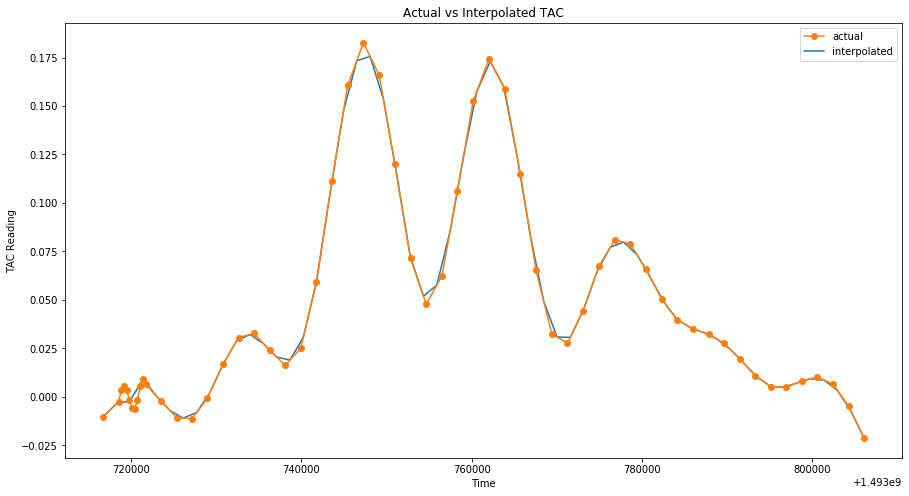

In [213]:
sa = all_tacs[all_tacs.pid=='SA0297']
ts = np.linspace(sa.timestamp.min(), sa.timestamp.max(), sa.timestamp.shape[0])
fig, ax = plt.subplots(figsize=(15,8))
f = interp1d(sa.timestamp, sa.TAC_Reading, kind='linear')
i, = ax.plot(ts, f(ts))
a, = ax.plot(sa.timestamp, sa.TAC_Reading, '-o')
plt.xlabel('Time')
plt.ylabel('TAC Reading')
plt.title('Actual vs Interpolated TAC')
plt.legend([a,i], ['actual', 'interpolated'])
plt.show()

##### Transformation Process

Using the interpolation method, we can transform the dataset as follows

- Filter accelerometer and TAC data for PID
- Extract accelerometer data between start and end times of TAC measurement
- Pick valid 10 second windows with 40 sample rate.
- Find interpolated TAC reading for each window.
- Append to new dataframe with vectorized x,y and z values
- Repeat for other participants (PIDs)

Perfect! Now, let's create the full converted data set using interpolation method for each pid

In [218]:
# setup acc_df
acc_df = pd.read_csv('data/all_accelerometer_data_pids_13.csv')
# sort by time of recording the data
acc_df.sort_values(by=['time'], inplace=True)
# create column with timestamp in seconds
acc_df['timestamp'] = acc_df['time']//1000
# setup all_tacs
pids = pd.read_csv(os.path.join('data', 'phone_types.csv'))
def tac_readings(pid):
    fname = glob.glob(os.path.join('data', 'clean_tac', f'{pid}*.csv'))[0]
    df = pd.read_csv(fname)
    df['pid'] = pid
    return df
all_tacs = pd.concat(pids.pid.apply(tac_readings).to_list())
# sort by timestamp
all_tacs.sort_values(by=['timestamp'], inplace=True)

In [411]:
def extract_segments(pid):
    # filter accelerometer readings for the pid
    acc_pid = acc_df[acc_df.pid == pid]
    # get TAC readings for the pid
    tacs_pid = all_tacs[all_tacs.pid == pid]
    # interpolation function for TAC readings of pid
    expected_tac = interp1d(tacs_pid.timestamp, tacs_pid.TAC_Reading, kind='linear')
    # get the start and end time for the TAC readings in seconds
    start, end = tacs_pid.timestamp.min(), tacs_pid.timestamp.max()
    # extract accelerator readings in the time frame TAC has been active
    acc_pid = acc_pid[(start <= acc_pid.timestamp) & (acc_pid.timestamp <= end)]
    acc_pid = acc_pid.sort_values(by=['time'])
    # 10 seconds grouping window
    acc_pid['ten_seconds_group'] = acc_pid.timestamp//10
    # select groups with 40 Hz sampling rate
    samples_in_groups = acc_pid.ten_seconds_group.value_counts()
    valid_groups = samples_in_groups[samples_in_groups == 400].index
    valid_groups_acc_pid = acc_pid[acc_pid['ten_seconds_group'].isin(valid_groups)]
    grouped = valid_groups_acc_pid.groupby('ten_seconds_group').agg(lambda s: s.to_list())
    grouped = grouped[['x', 'y', 'z', 'timestamp']]
    grouped['timestamp'] = grouped.timestamp.map(lambda x: x[0])
    grouped['tac'] = grouped.timestamp.map(lambda x: expected_tac(x))
    grouped['pid'] = pid
    return grouped

X = pd.concat(pids.pid.map(extract_segments).to_list())
X.pid.value_counts()

BK7610    1402
PC6771    1344
CC6740     965
SF3079     604
BU4707     479
MC7070     372
MJ8002     331
JR8022     273
HV0618      91
DK3500      11
JB3156       2
Name: pid, dtype: int64

##### Resampled Signals
By using interpolation, we got over 5000 records/signals for training. One thing to note is that there are a lot of sections sampled at higher than 40 hz. For example, for pid `JB3156`
```
1493760428    78
1493760426    50
1493760424    50
1493760423    50
1493760421    50
1493760420    50
1493760429    49
1493760427    49
1493760425    49
1493760422    49
```

Let us create a separate dataframe with resampled signals. We can train a classifier with and without resampled data and pick the one that performs the best.



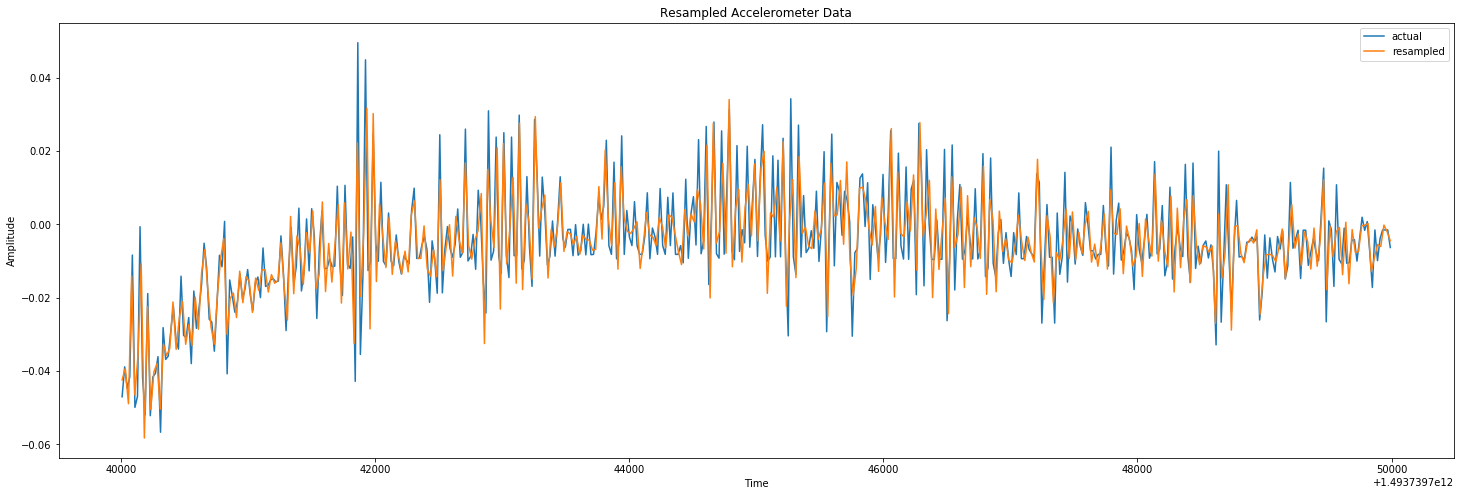

In [232]:
xs = acc_df[(acc_df.pid == 'JB3156') & (acc_df.timestamp >= 1493739740) & (acc_df.timestamp <= 1493739749)]
fig, ax = plt.subplots(figsize=(25,8))
ts = np.linspace(xs.time.min(), xs.time.max(), 496)
a, = ax.plot(ts, xs.x)
ts = np.linspace(xs.time.min(), xs.time.max(), 400)
r, = ax.plot(ts, librosa.resample(np.array(xs.x), len(xs), 400))
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title("Resampled Accelerometer Data")
plt.legend([a, r], ["actual", "resampled"])
plt.show()

From the plot, we can see that the resampled signal is very similar to the original

In [ ]:
sample_rate = 400
def extract_segments_with_resample(pid):
    # filter accelerometer readings for the pid
    acc_pid = acc_df[acc_df.pid == pid]
    # get TAC readings for the pid
    tacs_pid = all_tacs[all_tacs.pid == pid]
    # interpolation function for TAC readings of pid
    expected_tac = interp1d(tacs_pid.timestamp, tacs_pid.TAC_Reading, kind='linear')
    # get the start and end time for the TAC readings in seconds
    start, end = tacs_pid.timestamp.min(), tacs_pid.timestamp.max()
    # extract accelerator readings in the time frame TAC has been active
    acc_pid = acc_pid[(start <= acc_pid.timestamp) & (acc_pid.timestamp <= end)]
    acc_pid = acc_pid.sort_values(by=['time'])
    # 10 seconds grouping window
    acc_pid['ten_seconds_group'] = acc_pid.timestamp//10
    # select groups with 40 Hz sampling rate
    samples_in_groups = acc_pid.ten_seconds_group.value_counts()
    valid_groups = samples_in_groups[(samples_in_groups != 400) & (samples_in_groups > 375) & (samples_in_groups < 425)].index
    valid_groups_acc_pid = acc_pid[acc_pid['ten_seconds_group'].isin(valid_groups)]
    grouped = valid_groups_acc_pid.groupby('ten_seconds_group').agg(lambda s: s.to_list())
    grouped = grouped[['x', 'y', 'z', 'timestamp']]
    grouped['x'] = grouped['x'].apply(lambda x: librosa.resample(np.array(x), len(x), sample_rate))
    grouped['y'] = grouped['y'].apply(lambda x: librosa.resample(np.array(x), len(x), sample_rate))
    grouped['z'] = grouped['z'].apply(lambda x: librosa.resample(np.array(x), len(x), sample_rate))
    grouped['timestamp'] = grouped.timestamp.map(lambda x: x[0])
    grouped['tac'] = grouped.timestamp.map(lambda x: expected_tac(x))
    grouped['pid'] = pid
    return grouped

X_rescaled = pd.concat(pids.pid.map(extract_segments_with_resample).to_list())
X_rescaled.pid.value_counts()

In [ ]:
X_scaled.x.map(len)

### Feature Extraction Pipeline

The initial features I am extracting from the signals are RMS values of each frame in the segment and average of the STFT spectral information for each frame

In [413]:
class NumpyArrayConvertor():
    def transform(self, X, **fit_params):
        X['x'] = X['x'].apply(np.array)
        X['y'] = X['y'].apply(np.array)
        X['z'] = X['z'].apply(np.array)
        return X
    def fit(self, X, y=None, **fit_params):
        return self

class RMSCalculator():
    def transform(self, X, **fit_params):
        X['rms_x'] = X['x'].apply(rms)
        X['rms_y'] = X['y'].apply(rms)
        X['rms_z'] = X['z'].apply(rms)
        return X
    def fit(self, X, y=None, **fit_params):
        return self

class STFTCalculator():
    def transform(self, X, **fit_params):
        X['stft_x'] = X['x'].map(avg_stft_per_frame)
        X['stft_y'] = X['y'].map(avg_stft_per_frame)
        X['stft_z'] = X['z'].map(avg_stft_per_frame)
        return X
    def fit(self, X, y=None, **fit_params):
        return self

class FeaturesFlattener():
    def __init__(self, feature_cols):
        self.feature_cols = feature_cols
    def transform(self, X, **fit_params):
        return pd.concat([pd.DataFrame(X[c].tolist()) for c in feature_cols], axis=1)
    def fit(self, X, y=None, **fit_params):
        return self

def rms(x):
    return librosa.feature.rms(x, frame_length=frame_length, hop_length=frame_length, center=False)[0]

def avg_stft_per_frame(x):
    stft = librosa.amplitude_to_db(np.abs(librosa.stft(x, n_fft=frame_length, hop_length=frame_length, center=False)), ref=np.max)
    return stft.mean(axis=1)

# Values
sample_rate = 40
frame_length = sample_rate
feature_cols = ['rms_x', 'rms_y', 'rms_z', 'stft_x', 'stft_y', 'stft_z']

# Feature Extraction Pipeline
pl = Pipeline([("Convert signals to numpy arrays", NumpyArrayConvertor()),
               ("Calculate RMS values for signals", RMSCalculator()),
               ("Calculate average STFT vectors", STFTCalculator()),
               ("Flatten features into a 2D numpy array", FeaturesFlattener(feature_cols))
              ])

# y == True if TAC level > 0.8
y = (X.tac > 0.08).values
features = pl.fit_transform(X.copy())

y_rescaled = (X_rescaled.tac > 0.08).values
features_rescaled = pl.fit_transform(X_rescaled.copy())

## Classification

I train a Random Forest Classifier to predict the intoxication status of the user. RFC is a good fit for this task since it is fast and it can be trained on datasets with non-linear features and unbalanced class distributions. Class distribution of our dataset is as follows

In [382]:
print(f"The percentage of records for 'Intoxicated' class in the dataset is {np.round(y.mean(),3) * 100}")
print(f"The percentage of records for 'Intoxicated' class in the rescaled set is {np.round(y_rescaled.mean(),3) * 100}")

The percentage of records for 'Intoxicated' class in the dataset is 41.5
The percentage of records for 'Intoxicated' class in the rescaled set is 26.1


#### Process
- Shuffle the dataset to reduce overfitting
- Split the dataset into training (80%) and testing (20%) sets. Make sure class representation is equal in both sets.
- Set a seed for random state for reproducibility
- Train the classifier
- Examine classification report and accuracy
- Hyperparameter tuning

In [336]:
# train test split with shuffled stratified data
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, shuffle=True, stratify=y, random_state=1337)

# Sanity check for training set 
assert((X[X.rms_x.apply(lambda x: x[0] == X_train[100][0])].rms_x.values[0] != X_train[100][:10]).sum() == 0)

print(f"The percentage of records for 'Intoxicated' class in the training set is {np.round(y_train.mean(),3) * 100}")
print(f"The percentage of records for 'Intoxicated' class in the test set is {np.round(y_test.mean(),3) * 100}")

# train
clf = RandomForestClassifier(max_depth=5, random_state=1337, n_estimators=300, max_features=0.2)
clf.fit(X_train, y_train)

The percentage of records for 'Intoxicated' class in the training set is 41.5
The percentage of records for 'Intoxicated' class in the test set is 41.5


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features=0.2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=1337,
                       verbose=0, warm_start=False)

#### Evaluation

In [337]:
print(classification_report(y_test, clf.predict(X_test), labels=None, target_names=['Sober', 'Intoxicated'], sample_weight=None, digits=2, output_dict=False, zero_division='warn'))

              precision    recall  f1-score   support

       Sober       0.85      0.76      0.80       687
 Intoxicated       0.71      0.81      0.76       488

    accuracy                           0.78      1175
   macro avg       0.78      0.79      0.78      1175
weighted avg       0.79      0.78      0.78      1175



In [338]:
accuracy_score(y_test, clf.predict(X_test))

0.7829787234042553

In [392]:
np.where(pd.isnull(features_rescaled))

(array([    0,     0,     0, ..., 17245, 17245, 17245]),
 array([ 9, 19, 29, ...,  9, 19, 29]))

In [441]:
X_rescaled.x.apply(len).sort_values()

ten_seconds_group
149379093    376
149375832    376
149374291    376
149376475    376
149380124    376
            ... 
149375573    424
149378056    424
149375068    424
149376502    424
149379420    424
Name: x, Length: 17246, dtype: int64

In [437]:
features_rescaled

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.020440,0.009041,0.018517,0.024459,0.006879,0.006183,0.012189,0.007777,0.017742,NaN,...,-19.974384,-19.819780,-24.007483,-25.600859,-26.306341,-27.669724,-32.494522,-34.553333,-32.060516,-33.995575
1,0.034289,0.002837,0.002710,0.003863,0.003104,0.002700,0.026264,0.022528,0.045318,NaN,...,-30.165941,-35.758289,-35.490200,-36.280960,-39.316776,-40.318939,-41.472759,-43.990955,-46.783936,-49.677811
2,0.016642,0.049435,0.047156,0.027099,0.112822,0.040485,0.023608,0.027615,0.037488,NaN,...,-22.007685,-23.476078,-23.831230,-21.814812,-24.312193,-26.746521,-29.373117,-30.608589,-34.499935,-35.800964
3,0.022446,0.049213,0.019869,0.033930,0.044013,0.044077,0.018498,0.028897,0.065519,NaN,...,-25.320320,-28.615967,-27.615686,-27.633829,-31.626099,-32.077793,-37.619080,-36.063843,-36.848804,-40.476055
4,0.222006,0.251347,0.248774,0.173952,0.221609,0.118057,0.119021,0.171727,0.146929,NaN,...,-32.255417,-30.185768,-32.718914,-36.593704,-33.697807,-30.910048,-33.989513,-35.685135,-33.706345,-36.968922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17241,0.008650,0.012805,0.016426,0.028242,0.030240,0.044684,0.041536,0.034336,0.028728,NaN,...,-24.583639,-24.568813,-25.314074,-26.466452,-28.247429,-26.598324,-26.234215,-28.264227,-27.068897,-29.477173
17242,0.054391,0.061940,0.055673,0.026474,0.039432,0.048702,0.035118,0.014425,0.017574,NaN,...,-34.580948,-35.324554,-36.926075,-34.375961,-33.260983,-32.409718,-37.688881,-37.734165,-39.015942,-36.769485
17243,0.034127,0.066222,0.042710,0.026914,0.007400,0.006425,0.004288,0.004827,0.003500,NaN,...,-25.516933,-32.049248,-31.264191,-31.766659,-31.000332,-30.086779,-31.017326,-30.403893,-30.779314,-35.545853
17244,0.055811,0.037921,0.044559,0.040792,0.041035,0.023527,0.100351,0.066551,0.126032,NaN,...,-30.605612,-30.943878,-35.463730,-29.561663,-29.745657,-31.934282,-33.137589,-34.835228,-32.812542,-37.022717


In [423]:
y_rescaled = (X_rescaled.tac > 0.08).values
features_rescaled = pl.fit_transform(X_rescaled.copy())

In [435]:
features_rescaled.apply(lambda x: np.sum(pd.isnull(x))).sort_values()

0         0
15        0
14        0
13        0
12        0
      ...  
3         0
20        0
9     14580
9     14580
9     14580
Length: 93, dtype: int64

In [418]:
X_train, X_test, y_train, y_test = train_test_split(features_rescaled, y_rescaled, test_size=0.2, shuffle=True, stratify=y_rescaled, random_state=1337)
clf = RandomForestClassifier(max_depth=5, random_state=1337, n_estimators=300, max_features=0.2)
clf.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test), labels=None, target_names=['Sober', 'Intoxicated'], sample_weight=None, digits=2, output_dict=False, zero_division='warn'))

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

From the report above, we can see that the model is better at predicting if a person is sober. Depending on the importance of intoxication prediction, we can tune precision/recall of "Intoxicated" class. For example, if we should be conservative and not alert the user of intoxication unless the predicition confidence is high, we can decrease the class weight of 'Intoxicated' category so that its precision score would improve.

In [343]:
clf = MLPClassifier(hidden_layer_sizes=(100,20), activation='relu', solver='adam', learning_rate='constant', random_state=1337)
clf.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test), labels=None, target_names=['Sober', 'Intoxicated'], sample_weight=None, digits=2, output_dict=False, zero_division='warn'))
print("Accuracy:", accuracy_score(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

       Sober       0.85      0.81      0.83       687
 Intoxicated       0.75      0.81      0.78       488

    accuracy                           0.81      1175
   macro avg       0.80      0.81      0.80      1175
weighted avg       0.81      0.81      0.81      1175

Accuracy: 0.8068085106382978


This is formulated as a classification problem, but you are free to use any techniques or methods that you would like. I recommend starting off simply just to get some baseline models. Please report your accuracy and F1 scores.

Future Steps:
- Train Neural Network on the STFT spectrograms
- overlap using hop_length or not
- Class distribution balanced? all of our classifiers had a higher accuracy for sober data than intoxicated data and that the variance of our best classifier was high for intoxicated subjects
- We can train a classifier with and without resampled data and pick the one that performs the best.
- PCA, Scaler, Shuffle, Train test eval split, Use the resampled versions, change class weights to make X.tac yes or no 50-50 instead of 60-40

This is also a time-blocked exercise that I completed within 2 days. Hence, I mention multiple ideas in the future work section to expand on this initial analysis.